# Sentiment Analysis

First, lets go back to some previous results on how vooyai destination suggestions differ from real tourism stats.

# 
# ![Ranking Differences](figures/ranking_diffs.png)
# 

And let's try to find a cause for this. **Let's work under the hypothesis that prompt sentiment affects the results**.

In [17]:
#Imports
from dataloader import VooyaiDataloader
import pandas as pd
import numpy as np


dataset = VooyaiDataloader("data/")
ranking_df = pd.read_csv("data/ranking.csv")

# Rename 'country' column to 'Country' in ranking_df
ranking_df = ranking_df.rename(columns={'country': 'Country'})


es_df = dataset.destinations_df[dataset.destinations_df['language'] == 'es']

6890


We will use a model for spanish prompts and a different model for english prompts

In [ ]:
from pysentimiento import create_analyzer
import transformers

#Initialize sentiment analysis tools
analyzer_es = create_analyzer(task="sentiment", lang="es")
analyzer_en = create_analyzer(task="sentiment", lang="en")

#Get discoveries dataset:
#For example lets take an spanish prompt
discoveries_es = dataset.discoveries_df[dataset.discoveries_df['language'] == 'es'].reset_index(drop=True)
discoveries_en = dataset.discoveries_df[dataset.discoveries_df['language'] == 'en'].reset_index(drop=True)
discoveries_en.head(5)

We can see how in english we have prompts in other languages too from people who used the app on their own language, it would be an interesting task to clean prompts based on language without supervision, but more on that later...

In [3]:


print("Analyzing Spanish Prompt")
print("Spanish model: " ,analyzer_es.predict(discoveries_es.loc[0].prompt)) 
print("English model: " ,analyzer_en.predict(discoveries_es.loc[0].prompt)) 

print("Analyzing English Prompt")
print("Spanish model: " ,analyzer_es.predict(discoveries_en.loc[0].prompt)) 
print("English model: " ,analyzer_en.predict(discoveries_en.loc[0].prompt)) 


Analyzing Spanish Prompt
Spanish model:  AnalyzerOutput(output=NEU, probas={NEU: 0.604, POS: 0.350, NEG: 0.046})
English model:  AnalyzerOutput(output=NEU, probas={NEU: 0.946, POS: 0.049, NEG: 0.004})
Analyzing English Prompt
Spanish model:  AnalyzerOutput(output=POS, probas={POS: 0.547, NEU: 0.400, NEG: 0.053})
English model:  AnalyzerOutput(output=POS, probas={POS: 0.865, NEU: 0.133, NEG: 0.001})


We can see how there is a discrepancy in how models interpret sentiment if they are not tuned for the input language.

In this section we will focus on using the spanish language analyzer, as we have more spanish prompts, and we have not yet removed other languages from the english dataset (there are some prompts in the spanish subset in other languages but the landing page defaults to english so that's were other language users prompted)

In [ ]:
from tqdm import tqdm

tqdm.pandas()

#Lets get a sentiment score for each prompt. We will only keep id and prompt for this
ddf_es = discoveries_es[['id','prompt']]

def getSentiment(prompt):
    sentiment = analyzer_es.predict(prompt)
    return sentiment.probas

# Apply getSentiment function to each prompt and create new columns
ddf_es['sentiment'] = ddf_es['prompt'].progress_apply(getSentiment) #As it takes a while this is useful to check eta

# Extract sentiment scores into separate columns
ddf_es['neg'] = ddf_es['sentiment'].apply(lambda x: x['NEG'])
ddf_es['neu'] = ddf_es['sentiment'].apply(lambda x: x['NEU'])
ddf_es['pos'] = ddf_es['sentiment'].apply(lambda x: x['POS'])

# Drop the temporary 'sentiment' column
ddf_es = ddf_es.drop('sentiment', axis=1)

Now that we have sentiment, lets find out how this relates with the destinations suggested

In [13]:
#First lets create a new dataframe adding to each discovery the sentiment of the prompts.
# Merge the dataframes based on id and parent_id
combined_es_df = es_df.merge(ddf_es,how='left',left_on='parent_id',right_on='id')

#Remove redundant columns
combined_es_df = combined_es_df.drop(columns='id')

In [14]:
#Now we keep only the countries from the top 10
combined_es_df10 = combined_es_df[combined_es_df['countrycode'].isin(ranking_df['CC'])]

#And get some sentiment statistics per country.
cesdf10_stats = combined_es_df10.groupby('countrycode').agg({'neg':['mean','std'],'neu':['mean','std'],'pos':['mean','std']})
#Sort index so it matches the ranking one
cesdf10_stats = cesdf10_stats.reset_index().set_index('countrycode').loc[ranking_df['CC']].reset_index()


##### Lets compare ranking and sentiment

In [16]:
ranking_df.head(5)

,Unnamed: 0,real_rank,es_rank,en_rank,vooyai_rank,country,CC,vooyai_rank_diff,es_rank_diff,en_rank_diff
0,0,0,2,0,2,France,FR,-2,-2,0
1,1,1,0,1,0,Spain,ES,1,1,0
2,2,2,5,3,4,United States,US,-2,-3,-1
3,3,3,1,2,1,Italy,IT,2,2,1
4,4,4,23,49,25,Turkey,TR,-21,-19,-45


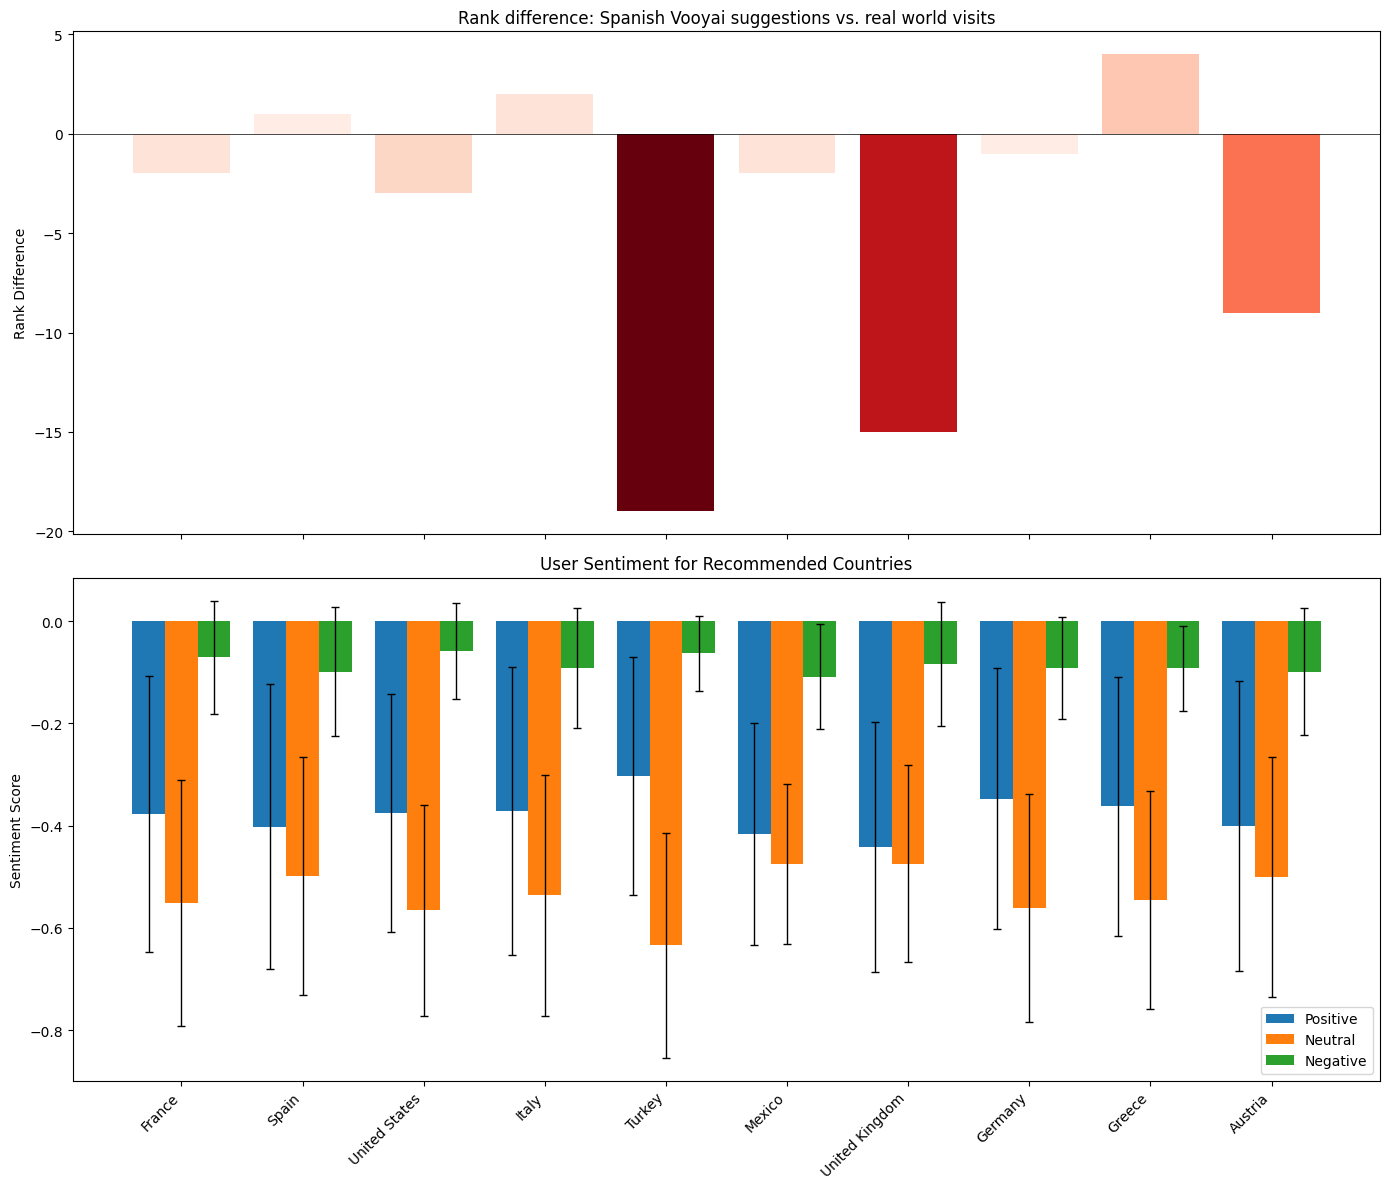

In [18]:
import matplotlib.pyplot as plt

#And now lets do some plotting.
plt.rcParams['axes.facecolor'] = 'white'
# Plotting
# Assuming you have your data in pandas DataFrames: ranking_df and sentiment_df

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12), sharex=True)

# Upper panel: Rank difference chart (your existing code)
colors = plt.cm.Reds(np.abs(ranking_df['es_rank_diff']) / np.abs(ranking_df['es_rank_diff']).max())
ax1.bar(ranking_df['Country'], ranking_df['es_rank_diff'], color=colors)
ax1.set_title('Rank difference: Spanish Vooyai suggestions vs. real world visits')
ax1.set_ylabel('Rank Difference')
ax1.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

# Lower panel: Sentiment chart
x = np.arange(len(ranking_df['Country']))
width = 0.27
error_kw=dict(lw=1, capsize=3, capthick=1)

# Assuming sentiment_df has columns: Country, pos_mean, neu_mean, neg_mean, pos_std, neu_std, neg_std
ax2.bar(x - width, -cesdf10_stats[('pos','mean')], width, label='Positive', yerr=cesdf10_stats[('pos','std')],error_kw=error_kw)
ax2.bar(x,- cesdf10_stats[('neu','mean')], width, label='Neutral', yerr=cesdf10_stats[('neu','std')],error_kw=error_kw)
ax2.bar(x + width, -cesdf10_stats[('neg','mean')], width, label='Negative', yerr=cesdf10_stats[('neg','std')],error_kw=error_kw)

ax2.set_ylabel('Sentiment Score')
ax2.set_title('User Sentiment for Recommended Countries')
ax2.set_xticks(x)
ax2.set_xticklabels(ranking_df['Country'], rotation=45, ha='right')
ax2.legend()
plt.tight_layout()
plt.show()

From the graphs it may seem that Turkey tends to get suggested more with neutral prompts, while positive prompts tend to not suggest Turkey compared to the other countries. Let's further explore this.


In [19]:
# Let's use the countries with small rank differences for comparison: France, Spain, USA, Italy, México and Germany.
countries_to_compare = ['FR', 'ES', 'US', 'IT','MX','DE']
comparison_data = combined_es_df10[combined_es_df10['countrycode'].isin(countries_to_compare)]

# Test if sentiments are significantly different between comparison countries and Turkey
turkey_data = combined_es_df10[combined_es_df10['countrycode'] == 'TR']

Visualize the distribution of scores for Turkey and other countries:

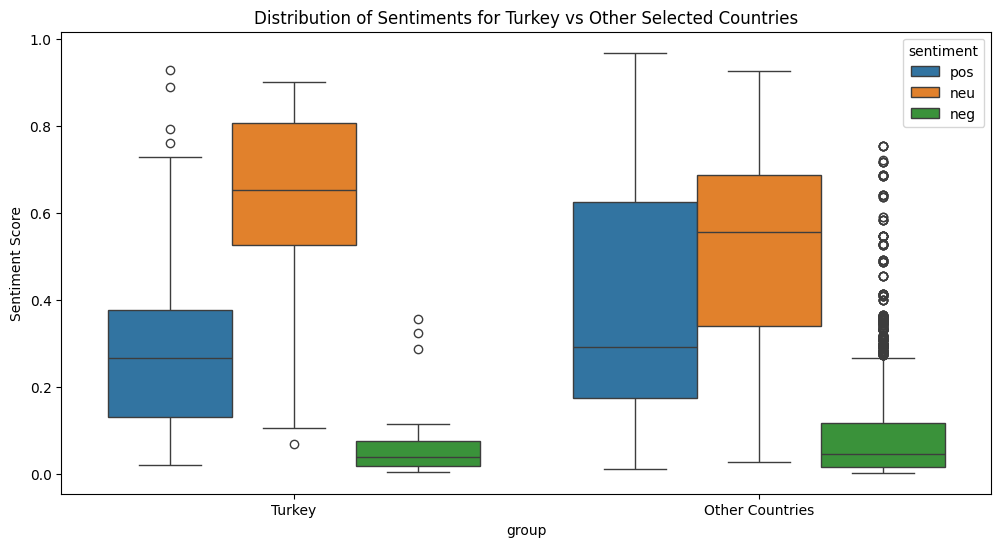

In [20]:
# Visualize the distribution of sentiments for Turkey and combined selected countries
import seaborn as sns

plt.figure(figsize=(12, 6))

# Prepare data for Turkey
turkey_melted = pd.melt(turkey_data, id_vars=['countrycode'], value_vars=['pos', 'neu', 'neg'], var_name='sentiment', value_name='score')
turkey_melted['group'] = 'Turkey'

# Prepare data for other countries (combined)
other_countries_melted = pd.melt(comparison_data, id_vars=['countrycode'], value_vars=['pos', 'neu', 'neg'], var_name='sentiment', value_name='score')
other_countries_melted['group'] = 'Other Countries'

# Combine the data
combined_melted = pd.concat([turkey_melted, other_countries_melted])

# Create the boxplot
sns.boxplot(x='group', y='score', hue='sentiment', data=combined_melted)
plt.title("Distribution of Sentiments for Turkey vs Other Selected Countries")
plt.ylabel("Sentiment Score")
plt.show()

We can see how turkey has lower positive scores and more neutral scores than other countries, although it also has less negatives.

Lets perform some statistical tests to see if this difference in distribution is significant.

In [21]:
# Perform statistical tests
from scipy import stats

# Perform Mann-Whitney U test so we dont assume normality.
sentiments = ['pos', 'neu', 'neg']
for sentiment in sentiments:
    u_stat, p_value = stats.mannwhitneyu(comparison_data[sentiment], turkey_data[sentiment])
    print(f"Statistical test for {sentiment} sentiment (Comparison countries vs Turkey):")
    n1, n2 = len(comparison_data), len(turkey_data)
    print(f"U-statistic: {u_stat} (n1={n1}, n2={n2})")
    print(f"P-value: {p_value}")
    print()

Statistical test for pos sentiment (Comparison countries vs Turkey):
U-statistic: 84250.0 (n1=2871, n2=50)
P-value: 0.03486196964697912

Statistical test for neu sentiment (Comparison countries vs Turkey):
U-statistic: 49677.0 (n1=2871, n2=50)
P-value: 0.00018577888521714334

Statistical test for neg sentiment (Comparison countries vs Turkey):
U-statistic: 75715.0 (n1=2871, n2=50)
P-value: 0.5051978305129257



From this test we can extract some early conclusions:

-  The U-value is higher than half of the maximum (143550) suggesting that other countries tend to have slightly higher positive sentiments than turkey.
-  On the other hand, the U-value for neutral is notably smaller than half of the maximum suggesting that the other countries get more neutral sentiment scores.
-  The U-value for negative is close to half of the maximum (143550/2 = 71775) suggesting that the distribution is similar, although it has a high p-value so this is not statistically significant.

Still, we can observe a huge discrepancy in sample size (2871 vs 50), which could affect the reliability of these results, so lets do some additional tests, using bootstrapping.

The idea is simple, sample multiple subsets from both groups that are as big as the smaller group, and compare them using again the Mann-Whitney U test. Then, keep the distribution of U-statistics and p-values of all comparisons, and calculate the mean of them. We do this for each sentiment. 


Bootstrapping for pos sentiment:


100%|██████████| 10000/10000 [00:04<00:00, 2226.39it/s]



Bootstrapping for neu sentiment:


100%|██████████| 10000/10000 [00:04<00:00, 2215.58it/s]



Bootstrapping for neg sentiment:


100%|██████████| 10000/10000 [00:04<00:00, 2230.83it/s]



Pos Sentiment:
Mean U-statistic: 1467.35
Median U-statistic: 1467.50
Proportion of significant results (p < 0.05): 32.05%

Neu Sentiment:
Mean U-statistic: 863.34
Median U-statistic: 860.00
Proportion of significant results (p < 0.05): 77.26%

Neg Sentiment:
Mean U-statistic: 1319.14
Median U-statistic: 1318.00
Proportion of significant results (p < 0.05): 8.10%


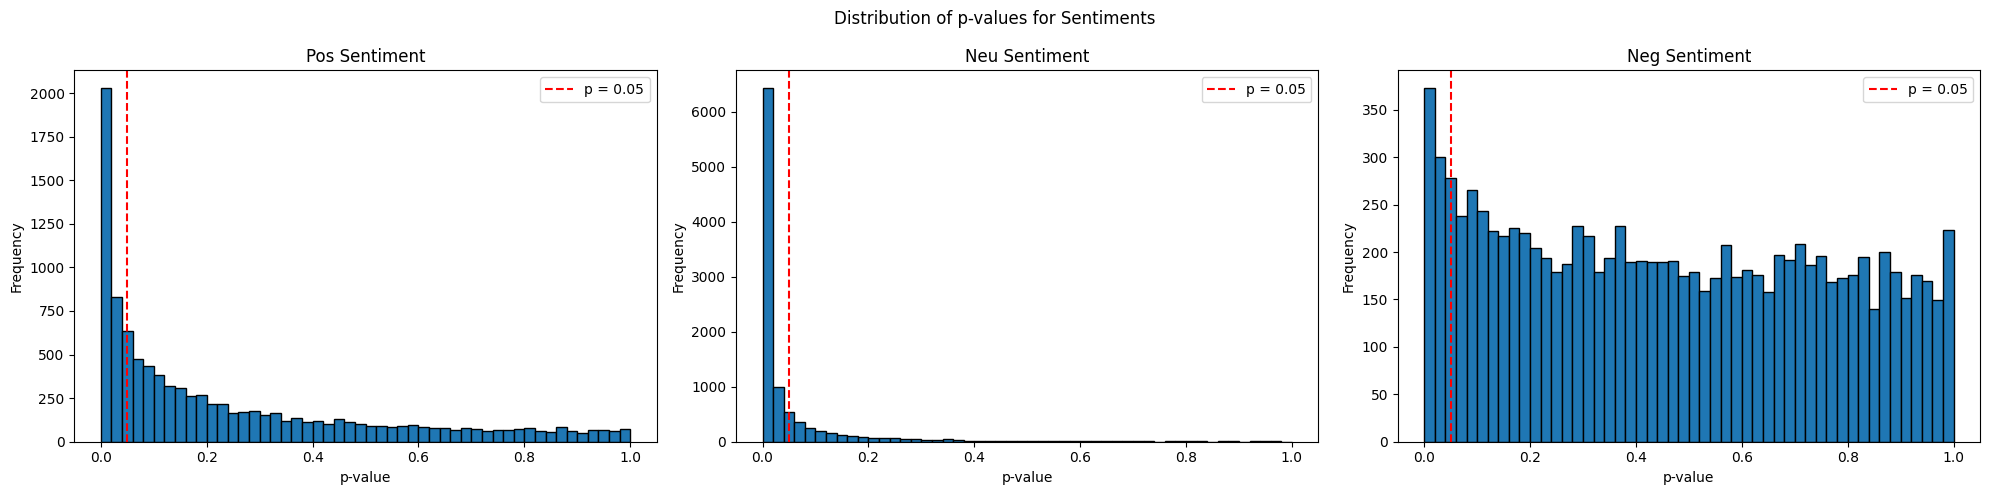

In [22]:
import numpy as np
from scipy import stats
from tqdm import tqdm

def bootstrap_mann_whitney(group1, group2, n_iterations=10000):
    n_small = len(group2)  # Turkey sample size
    u_stats = []
    p_values = []
    
    for _ in tqdm(range(n_iterations)):
        # Resample Turkey data with replacement
        boot_turkey = np.random.choice(group2, size=n_small, replace=True)
        
        # Sample equal size from comparison countries
        boot_comparison = np.random.choice(group1, size=n_small, replace=False)
        
        # Perform Mann-Whitney U test
        u_stat, p_value = stats.mannwhitneyu(boot_comparison, boot_turkey)
        
        u_stats.append(u_stat)
        p_values.append(p_value)
    
    return np.array(u_stats), np.array(p_values)

# Perform bootstrapping for each sentiment
sentiments = ['pos', 'neu', 'neg']
results = {}

for sentiment in sentiments:
    print(f"\nBootstrapping for {sentiment} sentiment:")
    u_stats, p_values = bootstrap_mann_whitney(comparison_data[sentiment], turkey_data[sentiment])
    results[sentiment] = {'u_stats': u_stats, 'p_values': p_values}

# Analyze results
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle('Distribution of p-values for Sentiments')

for i, sentiment in enumerate(sentiments):
    u_stats = results[sentiment]['u_stats']
    p_values = results[sentiment]['p_values']
    
    print(f"\n{sentiment.capitalize()} Sentiment:")
    print(f"Mean U-statistic: {np.mean(u_stats):.2f}")
    print(f"Median U-statistic: {np.median(u_stats):.2f}")
    print(f"Proportion of significant results (p < 0.05): {np.mean(p_values < 0.05):.2%}")

    # Visualize distribution of p-values
    axes[i].hist(p_values, bins=50, edgecolor='black')
    axes[i].set_title(f'{sentiment.capitalize()} Sentiment')
    axes[i].set_xlabel('p-value')
    axes[i].set_ylabel('Frequency')
    axes[i].axvline(0.05, color='red', linestyle='--', label='p = 0.05')
    axes[i].legend()

plt.tight_layout()
plt.show()

If we now analyze these results:
  - We can seee how for positive sentiment, the U statistic is higher than half of the maximum (now is 50*50 = 2500), implying that other countries tend to have more positive sentiment, still now we can see how only about one third of the bootstrapping tests had a significant p-value, so its is not consistently different.
  - On the other hand, for Neutral sentiment we have a much slower U statistic, and 77% of tests had a significance smaller than 0.05, suggesting that indeed Turkey has more neutral scores with statistical significance
  - Negative sentiment has a value near half the maximum, but a very small significance, so there is no consistent difference in negative sentiment between turkey and other countries.

Turkey consistently shows higher neutral scores than other countries.

Lets see if thats also the case for UK

In [23]:
# Test if sentiments are significantly different between comparison countries and Turkey
uk_data = combined_es_df10[combined_es_df10['countrycode'] == 'GR']
len(uk_data)

202

In [24]:
# Perform Mann-Whitney U test so we dont assume normality.
sentiments = ['pos', 'neu', 'neg']
for sentiment in sentiments:
    u_stat, p_value = stats.mannwhitneyu(comparison_data[sentiment], uk_data[sentiment])
    print(f"Statistical test for {sentiment} sentiment (Comparison countries vs Turkey):")
    n1, n2 = len(comparison_data), len(uk_data)
    print(f"U-statistic: {u_stat} (n1={n1}, n2={n2})")
    print(f"P-value: {p_value}")
    print()

Statistical test for pos sentiment (Comparison countries vs Turkey):
U-statistic: 304146.5 (n1=2871, n2=202)
P-value: 0.24483841936331963

Statistical test for neu sentiment (Comparison countries vs Turkey):
U-statistic: 266696.5 (n1=2871, n2=202)
P-value: 0.05619773085933091

Statistical test for neg sentiment (Comparison countries vs Turkey):
U-statistic: 276083.5 (n1=2871, n2=202)
P-value: 0.2545575089688714



Al values are close to half the maximum (~290k), with only neutral sentiment more notably below, and a p-value bigger than (albeit close to) 0.05, suggesting there may be again a different distribution for neutral sentiment.

So we again perfom bootstrapping


Bootstrapping for pos sentiment:


100%|██████████| 10000/10000 [00:04<00:00, 2038.69it/s]



Bootstrapping for neu sentiment:


100%|██████████| 10000/10000 [00:04<00:00, 2012.65it/s]



Bootstrapping for neg sentiment:


100%|██████████| 10000/10000 [00:04<00:00, 2066.80it/s]



Pos Sentiment:
Mean U-statistic: 21406.21
Median U-statistic: 21401.00
Proportion of significant results (p < 0.05): 13.53%

Neu Sentiment:
Mean U-statistic: 18785.65
Median U-statistic: 18796.00
Proportion of significant results (p < 0.05): 27.77%

Neg Sentiment:
Mean U-statistic: 19419.58
Median U-statistic: 19412.75
Proportion of significant results (p < 0.05): 13.05%


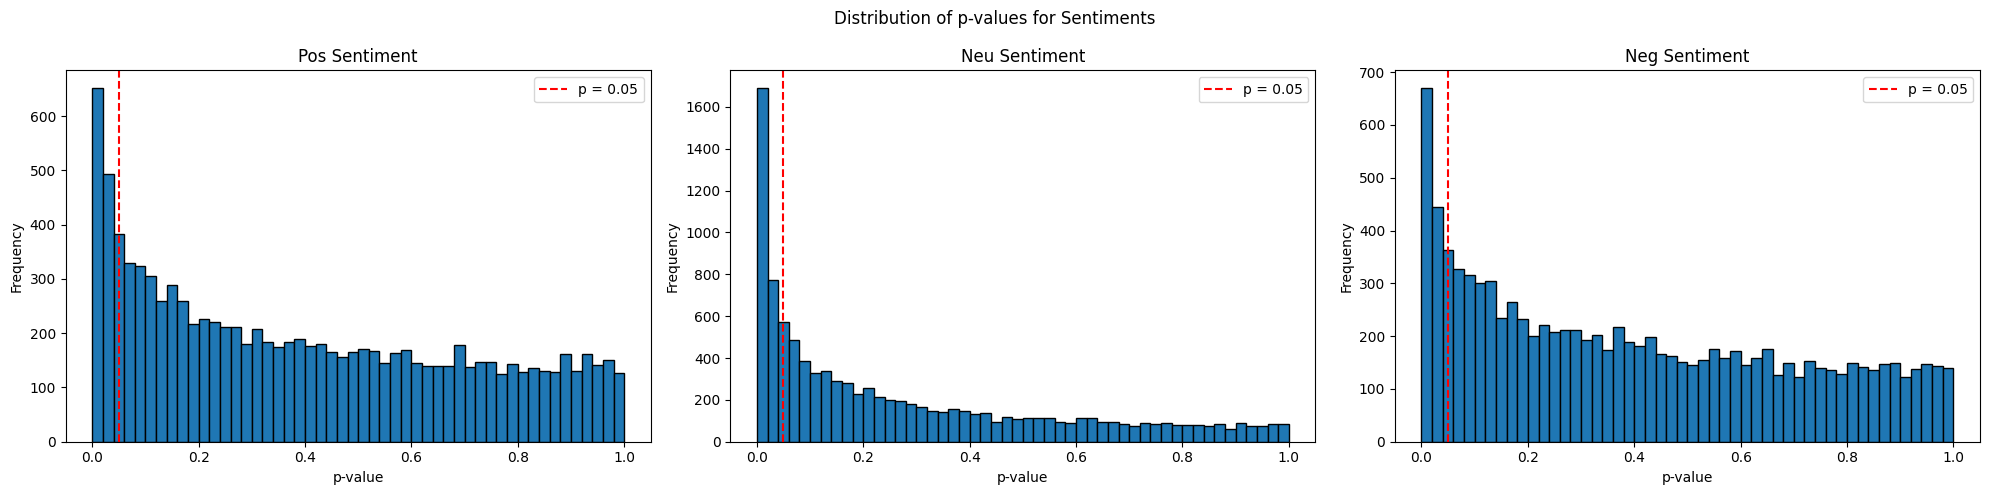

In [25]:
# Perform bootstrapping for each sentiment
sentiments = ['pos', 'neu', 'neg']
results = {}

for sentiment in sentiments:
    print(f"\nBootstrapping for {sentiment} sentiment:")
    u_stats, p_values = bootstrap_mann_whitney(comparison_data[sentiment], uk_data[sentiment])
    results[sentiment] = {'u_stats': u_stats, 'p_values': p_values}

# Analyze results
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle('Distribution of p-values for Sentiments')

for i, sentiment in enumerate(sentiments):
    u_stats = results[sentiment]['u_stats']
    p_values = results[sentiment]['p_values']
    
    print(f"\n{sentiment.capitalize()} Sentiment:")
    print(f"Mean U-statistic: {np.mean(u_stats):.2f}")
    print(f"Median U-statistic: {np.median(u_stats):.2f}")
    print(f"Proportion of significant results (p < 0.05): {np.mean(p_values < 0.05):.2%}")

    # Visualize distribution of p-values
    axes[i].hist(p_values, bins=50, edgecolor='black')
    axes[i].set_title(f'{sentiment.capitalize()} Sentiment')
    axes[i].set_xlabel('p-value')
    axes[i].set_ylabel('Frequency')
    axes[i].axvline(0.05, color='red', linestyle='--', label='p = 0.05')
    axes[i].legend()

plt.tight_layout()
plt.show()

And we can see how with bootstrapping the proportion of significant results is low with only 28.7% of them being lower than 0.05, so we cannot conclude the distribution is significantly different to that of other countries for UK

##### To close this sentiment section, lets calculate correlations between rank and sentiment scores

In [28]:
#Now lets see if there is some correlation with this.
from scipy.stats import spearmanr

# Merge ranking information with the combined dataset
full_data = combined_es_df10.merge(ranking_df[['Country', 'es_rank_diff']], 
                                   left_on='countrycode', 
                                   right_on=ranking_df['CC'],how='left')

# Function to format and print correlation results
def print_correlations(correlations):
    for corr_type, sentiments in correlations.items():
        print('\n')
        for sentiment, (statistic, pvalue) in sentiments.items():
            print(f"{corr_type:<8} {sentiment:<8} Statistic: {statistic:8.4f}   P-value:{pvalue:8.4f}")
        

In [29]:
# Calculate correlations
correlations_original = {
    'Spearman': {
        'Positive': spearmanr(np.abs(full_data['es_rank_diff']), full_data['pos']),
        'Negative': spearmanr(np.abs(full_data['es_rank_diff']), full_data['neg']),
        'Neutral': spearmanr(np.abs(full_data['es_rank_diff']), full_data['neu'])
    },
}
# Print results for both
print("Correlations:")
print_correlations(correlations_original)



Correlations:


Spearman Positive Statistic:  -0.0336   P-value:  0.0561
Spearman Negative Statistic:  -0.0661   P-value:  0.0002
Spearman Neutral  Statistic:   0.0749   P-value:  0.0000


The correlations are very weak across all sentiments, with the strongest being only 0.0749 for neutral sentiment. 

Negative sentiment is negatively correlated, suggesting that a higher negative score results in a slower rank, which is the opposite of our initial guess. Still, it is a very weak correlation and probably not meaningful.

Neutral sentiment on the other hand its correlated, suggesting that a h igher neutral score results in a higher rank, but again, this is a very weak correlation and probably not meaningful.